# Import library

packages allowed for use during inference

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms



import imageio.v2 as imageio
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd

from sklearn.manifold import TSNE

packages during training

In [2]:
from thop import profile

# Hyperparameters

In [3]:
BATCH_SIZE = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Custom Dataset

custom dataset

先計算此training dataset的mean & std (直接用imagenet的)

In [4]:
train_mean = [0.485, 0.456, 0.406]
train_std = [0.229, 0.224, 0.225]

Custom dataset

In [5]:
# dataset整理image & label (from image folder & csv file)
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file) #csv_file : csv file path
        self.root_dir = root_dir #train folder 位置
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1])
        image = Image.open(img_name).convert("RGB") #image is PIL image
        label = int(self.data_frame.iloc[idx, 2])  # Get the label
        
        if self.transform:
            image = self.transform(image)

        return image, label


建train transform和val transform

val transform和test transform一樣

In [6]:
# Data Transformations
transform_train = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.05), ratio=(0.3, 3.3), value=0)
])

transform_val = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
])


用P2_train_val_CustomDataset產生custom train & val dataset，再產生trainloader & valloader

In [7]:
train_dataset = CustomDataset(csv_file='../../../hw1_data/p1_data/office/train.csv', root_dir='../../../hw1_data/p1_data/office/train', transform=transform_train)
val_dataset = CustomDataset(csv_file='../../../hw1_data/p1_data/office/val.csv', root_dir='../../../hw1_data/p1_data/office/val', transform=transform_val)

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [8]:
# print shape
image_first_batch, label_first_batch = next(iter(trainloader))  #get first batch's image & mask
print("type(image_first_batch): ", type(image_first_batch))
print("image_first_batch.shape: ", image_first_batch.shape)
print("type(label_first_batch): ", type(label_first_batch))
print("label_first_batch.shape: ", label_first_batch.shape)

type(image_first_batch):  <class 'torch.Tensor'>
image_first_batch.shape:  torch.Size([128, 3, 128, 128])
type(label_first_batch):  <class 'torch.Tensor'>
label_first_batch.shape:  torch.Size([128])


In [9]:
print(image_first_batch[2][0][100][102])
print(label_first_batch[2])

tensor(1.6324)
tensor(63)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


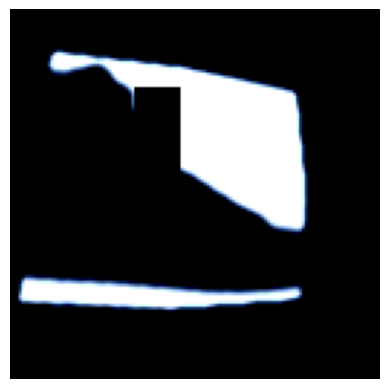

In [10]:
# visualize wo normalization
idx = 1
first_image = image_first_batch[idx]


# Convert the tensor to numpy array
image_np = first_image.numpy()
# Since matplotlib expects images in H x W x C format, we need to transpose it
image_np = np.transpose(image_np, (1, 2, 0))

# Plot the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [12]:
print(torch.cuda.is_available())

True


# Build Model

instance model
 
B set: 載入SL訓練的WEIGHT(由TA提供)


In [11]:
backbone = models.resnet50(weights=None)  # No pretrained weights
# Number of input features to the original FC layer
num_features = backbone.fc.in_features  # Typically 2048 for ResNet50 
print(num_features)
backbone.fc = torch.nn.Identity()  # Remove the final classification layer
# B set:
backbone.load_state_dict(torch.load('../../../hw1_data/p1_data/pretrain_model_SL.pt'), strict=False) # load the backbone weights

print()

#backbone is on cpu

2048


/tmp/ipykernel_19912/1331498443.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  backbone.load_state_dict(torch.load('../../../hw1_data/p1_data/pretrain_model_SL.pt'), st

 **B set:** train full model

 將resnet的fc替換成custom classifier 

In [13]:
# Create CombinedModel with custom classifier
class CombinedModel(nn.Module):
    def __init__(self, Backbone, num_features, hidden1=512, hidden2=256, num_classes=65, dropout_prob=0.5):
        super(CombinedModel, self).__init__()
        #Backbone
        self.Backbone = Backbone
        # First layer
        self.fc1 = nn.Linear(num_features, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)  # Batch Normalization for first hidden layer
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)  # Dropout after first hidden layer

        # Second layer
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)  # Batch Normalization for second hidden layer
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_prob)  # Dropout after second hidden layer

        # Final layer (output)
        self.fc3 = nn.Linear(hidden2, num_classes)

    def forward(self, x):
        # Backbone(already replace fc layer by identity)
        x = self.Backbone(x)
        # Forward through the first layer
        x = self.fc1(x)
        x = self.bn1(x)  # Batch normalization
        x = self.relu1(x)
        x = self.dropout1(x)  # Dropout
        
        # Forward through the second layer # Second Last layer(fc layer)
        x = self.fc2(x)
        x = self.bn2(x)  # Batch normalization
        x = self.relu2(x)
        x = self.dropout2(x)  # Dropout

        # Output layer (no activation, used for logits) # Last layer
        x = self.fc3(x)
        return x
    
    def get_second_last_layer_output(self, x):
        # Backbone(already replace fc layer by identity)
        x = self.Backbone(x)
        # Forward through the first layer
        x = self.fc1(x)
        x = self.bn1(x)  # Batch normalization
        x = self.relu1(x)
        x = self.dropout1(x)  # Dropout
        
        # Forward through the second layer (this is where we stop)
        x = self.fc2(x)
        x = self.bn2(x)  # Batch normalization
        x = self.relu2(x)
        x = self.dropout2(x)  # Dropout
        
        # Return the second-to-last layer output
        return x


# Replace the final fully connected layer in ResNet50 with the new MLP head
net = CombinedModel(Backbone=backbone, num_features=num_features)
net = net.to(device)


In [14]:
net.eval()
print(net)
#Compute MACs & params
input1 = torch.randn(1,3,128,128).to(device) # dummy input也放到device
MACs, params = profile(net, inputs=(input1, ))
print('MACs = ' + str(MACs/1000**3) + 'G')
print('Params = ' + str(params/1000**2) + 'M')

CombinedModel(
  (Backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [17]:
#print output shape
input1 = torch.randn(1,3,128,128).to(device) # dummy input也放到device
output_secondlast = net.get_second_last_layer_output(input1)
output = net(input1)
print(output.shape)
print(output_secondlast.shape)

torch.Size([1, 65])
torch.Size([1, 256])


# Training

Loss and Optimizer and epoch_n

In [18]:
# Loss function with label smoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.0):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.num_classes = num_classes

    def forward(self, pred, target):
        # Convert target to one-hot format
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        
        return torch.mean(torch.sum(-true_dist * torch.log_softmax(pred, dim=1), dim=1))

In [19]:
#criterion = nn.CrossEntropyLoss()
# Create Label Smoothing loss instance
criterion = LabelSmoothingLoss(num_classes=65, smoothing=0.1)
# Initialize optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
# Different base learning rate and update strategy #!!!!!!
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)  #if 5個epoch沒進步==> lr *= 0.5
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.6, last_epoch=-1)
# number of epoch
num_epochs = 100

training & validation loop

In [20]:
# Training and Validation Loop
best_val_acc = 0


for epoch in range(num_epochs):

    net.train() #開啟BN & DROPOUT
    train_loss = 0
    total_train = 0
    correct_train = 0

    for images, targets in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):  #進度條以batch完成度為趴數
        
        images, targets = images.to(device), targets.to(device)# model, input image, output, mask(target, label, GT) are moved to GPU during training

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0) #計算all dataset len
        correct_train += predicted.eq(targets.data).cpu().sum()

    train_loss /= len(trainloader)
    acc1 = correct_train / total_train



    # Validate
    net.eval() #關掉BN & DROPOUT
    val_loss = 0
    total_val = 0
    correct_val = 0

    with torch.no_grad():
        for images, targets in tqdm(valloader, desc='Validation', unit='batch'):
            images, targets = images.to(device), targets.to(device)

            outputs = net(images)  #(bs, 7, 512, 512)
            loss = criterion(outputs, targets) 


            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += targets.size(0) #計算all dataset len
            correct_val += predicted.eq(targets.data).cpu().sum()

    
    val_loss /= len(valloader)
    acc2 = correct_val / total_val
    
    # Save best model
    if acc2 > best_val_acc:
        best_val_acc = acc2
        #torch.save(net.state_dict(), os.path.join("../../../", "checkpoint_model", "P1", "Fine_tune", "A", "best_val_acc_model.pth")) # only C set need to save the model
        print(f'best model update,  val acc: {acc2:.4f}')


    scheduler.step(acc2)


    # Logging
    print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train acc: {acc1:.4f} - Val Loss: {val_loss:.4f} - Val acc: {acc2:.4f}')
    print(f'Learning rate: {scheduler.get_last_lr()[0]}')

Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


best model update,  val acc: 0.1502
Epoch 1/100 - Train Loss: 4.1435 - Train acc: 0.0463 - Val Loss: 3.8833 - Val acc: 0.1502
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


best model update,  val acc: 0.1773
Epoch 2/100 - Train Loss: 3.8191 - Train acc: 0.1121 - Val Loss: 3.8595 - Val acc: 0.1773
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


best model update,  val acc: 0.2118
Epoch 3/100 - Train Loss: 3.5979 - Train acc: 0.1658 - Val Loss: 3.2493 - Val acc: 0.2118
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


best model update,  val acc: 0.2241
Epoch 4/100 - Train Loss: 3.4211 - Train acc: 0.1999 - Val Loss: 3.2009 - Val acc: 0.2241
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


best model update,  val acc: 0.2512
Epoch 5/100 - Train Loss: 3.2998 - Train acc: 0.2275 - Val Loss: 3.1317 - Val acc: 0.2512
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


best model update,  val acc: 0.2759
Epoch 6/100 - Train Loss: 3.1994 - Train acc: 0.2493 - Val Loss: 3.0680 - Val acc: 0.2759
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


best model update,  val acc: 0.2980
Epoch 7/100 - Train Loss: 3.1362 - Train acc: 0.2650 - Val Loss: 2.9656 - Val acc: 0.2980
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 8/100 - Train Loss: 3.0326 - Train acc: 0.2913 - Val Loss: 3.0053 - Val acc: 0.2882
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 9/100 - Train Loss: 2.9766 - Train acc: 0.3088 - Val Loss: 3.1389 - Val acc: 0.2808
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


best model update,  val acc: 0.3571
Epoch 10/100 - Train Loss: 2.9320 - Train acc: 0.3252 - Val Loss: 2.8368 - Val acc: 0.3571
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 11/100 - Train Loss: 2.8515 - Train acc: 0.3432 - Val Loss: 2.9640 - Val acc: 0.3251
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 12/100 - Train Loss: 2.8139 - Train acc: 0.3564 - Val Loss: 2.8640 - Val acc: 0.3300
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 13/100 - Train Loss: 2.7432 - Train acc: 0.3753 - Val Loss: 2.9157 - Val acc: 0.3424
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 14/100 - Train Loss: 2.7388 - Train acc: 0.3733 - Val Loss: 2.7811 - Val acc: 0.3498
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


best model update,  val acc: 0.3719
Epoch 15/100 - Train Loss: 2.6636 - Train acc: 0.3999 - Val Loss: 2.7338 - Val acc: 0.3719
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/batch]


Epoch 16/100 - Train Loss: 2.6040 - Train acc: 0.4110 - Val Loss: 2.7082 - Val acc: 0.3695
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/batch]


best model update,  val acc: 0.3842
Epoch 17/100 - Train Loss: 2.5983 - Train acc: 0.4146 - Val Loss: 2.7644 - Val acc: 0.3842
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 18/100 - Train Loss: 2.5604 - Train acc: 0.4239 - Val Loss: 2.7882 - Val acc: 0.3719
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 19/100 - Train Loss: 2.5175 - Train acc: 0.4472 - Val Loss: 2.9058 - Val acc: 0.3276
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


best model update,  val acc: 0.3916
Epoch 20/100 - Train Loss: 2.5153 - Train acc: 0.4315 - Val Loss: 2.6493 - Val acc: 0.3916
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 21/100 - Train Loss: 2.4370 - Train acc: 0.4614 - Val Loss: 2.7400 - Val acc: 0.3793
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 22/100 - Train Loss: 2.4388 - Train acc: 0.4756 - Val Loss: 2.6808 - Val acc: 0.3916
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 23/100 - Train Loss: 2.3604 - Train acc: 0.4946 - Val Loss: 2.8113 - Val acc: 0.3719
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


best model update,  val acc: 0.4212
Epoch 24/100 - Train Loss: 2.3204 - Train acc: 0.4971 - Val Loss: 2.5287 - Val acc: 0.4212
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 25/100 - Train Loss: 2.3099 - Train acc: 0.5123 - Val Loss: 2.7969 - Val acc: 0.3793
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 26/100 - Train Loss: 2.3031 - Train acc: 0.5052 - Val Loss: 2.7703 - Val acc: 0.3916
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 27/100 - Train Loss: 2.2917 - Train acc: 0.5100 - Val Loss: 2.6572 - Val acc: 0.4015
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 28/100 - Train Loss: 2.2526 - Train acc: 0.5282 - Val Loss: 2.6168 - Val acc: 0.4064
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


best model update,  val acc: 0.4236
Epoch 29/100 - Train Loss: 2.1872 - Train acc: 0.5411 - Val Loss: 2.5960 - Val acc: 0.4236
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 30/100 - Train Loss: 2.1671 - Train acc: 0.5518 - Val Loss: 2.6891 - Val acc: 0.4039
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 31/100 - Train Loss: 2.1209 - Train acc: 0.5707 - Val Loss: 2.7476 - Val acc: 0.4064
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 32/100 - Train Loss: 2.1093 - Train acc: 0.5669 - Val Loss: 2.8388 - Val acc: 0.3744
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 33/100 - Train Loss: 2.1240 - Train acc: 0.5639 - Val Loss: 2.7693 - Val acc: 0.3793
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/batch]


best model update,  val acc: 0.4286
Epoch 34/100 - Train Loss: 2.0711 - Train acc: 0.5877 - Val Loss: 2.7096 - Val acc: 0.4286
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


best model update,  val acc: 0.4581
Epoch 35/100 - Train Loss: 2.0702 - Train acc: 0.5756 - Val Loss: 2.6092 - Val acc: 0.4581
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 36/100 - Train Loss: 2.0199 - Train acc: 0.6044 - Val Loss: 2.5733 - Val acc: 0.4507
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 37/100 - Train Loss: 2.0228 - Train acc: 0.5971 - Val Loss: 2.7034 - Val acc: 0.4138
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/batch]


Epoch 38/100 - Train Loss: 1.9680 - Train acc: 0.6140 - Val Loss: 2.6482 - Val acc: 0.4483
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 39/100 - Train Loss: 1.9378 - Train acc: 0.6292 - Val Loss: 2.9066 - Val acc: 0.4163
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.61s/batch]


Epoch 40/100 - Train Loss: 1.9233 - Train acc: 0.6338 - Val Loss: 2.8606 - Val acc: 0.4212
Learning rate: 0.001


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 41/100 - Train Loss: 1.9336 - Train acc: 0.6360 - Val Loss: 2.5586 - Val acc: 0.4458
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/batch]


best model update,  val acc: 0.4828
Epoch 42/100 - Train Loss: 1.7302 - Train acc: 0.7102 - Val Loss: 2.4295 - Val acc: 0.4828
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/batch]


Epoch 43/100 - Train Loss: 1.6780 - Train acc: 0.7342 - Val Loss: 2.4359 - Val acc: 0.4680
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/batch]


Epoch 44/100 - Train Loss: 1.5999 - Train acc: 0.7535 - Val Loss: 2.4423 - Val acc: 0.4828
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 45/100 - Train Loss: 1.5542 - Train acc: 0.7722 - Val Loss: 2.5000 - Val acc: 0.4631
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 46/100 - Train Loss: 1.5384 - Train acc: 0.7747 - Val Loss: 2.4004 - Val acc: 0.4704
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


best model update,  val acc: 0.5148
Epoch 47/100 - Train Loss: 1.5375 - Train acc: 0.7752 - Val Loss: 2.4778 - Val acc: 0.5148
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 48/100 - Train Loss: 1.5140 - Train acc: 0.7932 - Val Loss: 2.4371 - Val acc: 0.4778
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 49/100 - Train Loss: 1.4909 - Train acc: 0.7920 - Val Loss: 2.4856 - Val acc: 0.4926
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 50/100 - Train Loss: 1.4778 - Train acc: 0.7990 - Val Loss: 2.6032 - Val acc: 0.4655
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 51/100 - Train Loss: 1.4567 - Train acc: 0.8036 - Val Loss: 2.6050 - Val acc: 0.4729
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 52/100 - Train Loss: 1.4379 - Train acc: 0.8168 - Val Loss: 2.5007 - Val acc: 0.4877
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


best model update,  val acc: 0.5172
Epoch 53/100 - Train Loss: 1.4323 - Train acc: 0.8165 - Val Loss: 2.4009 - Val acc: 0.5172
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 54/100 - Train Loss: 1.4022 - Train acc: 0.8274 - Val Loss: 2.5430 - Val acc: 0.4803
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 55/100 - Train Loss: 1.3941 - Train acc: 0.8327 - Val Loss: 2.6035 - Val acc: 0.4901
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 56/100 - Train Loss: 1.3856 - Train acc: 0.8319 - Val Loss: 2.6905 - Val acc: 0.4631
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/batch]


Epoch 57/100 - Train Loss: 1.3741 - Train acc: 0.8299 - Val Loss: 2.5411 - Val acc: 0.4828
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 58/100 - Train Loss: 1.3560 - Train acc: 0.8411 - Val Loss: 2.5321 - Val acc: 0.4631
Learning rate: 0.0005


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/batch]


Epoch 59/100 - Train Loss: 1.3459 - Train acc: 0.8451 - Val Loss: 2.6187 - Val acc: 0.4680
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 60/100 - Train Loss: 1.2842 - Train acc: 0.8638 - Val Loss: 2.3707 - Val acc: 0.5049
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 61/100 - Train Loss: 1.2403 - Train acc: 0.8821 - Val Loss: 2.4842 - Val acc: 0.4901
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 62/100 - Train Loss: 1.2070 - Train acc: 0.8955 - Val Loss: 2.4142 - Val acc: 0.5148
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 63/100 - Train Loss: 1.2101 - Train acc: 0.8962 - Val Loss: 2.4624 - Val acc: 0.4877
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 64/100 - Train Loss: 1.1970 - Train acc: 0.9046 - Val Loss: 2.4161 - Val acc: 0.5123
Learning rate: 0.00025


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/batch]


Epoch 65/100 - Train Loss: 1.1639 - Train acc: 0.9139 - Val Loss: 2.4381 - Val acc: 0.5148
Learning rate: 0.000125


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 66/100 - Train Loss: 1.1347 - Train acc: 0.9203 - Val Loss: 2.4274 - Val acc: 0.5099
Learning rate: 0.000125


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/batch]


best model update,  val acc: 0.5271
Epoch 67/100 - Train Loss: 1.1250 - Train acc: 0.9296 - Val Loss: 2.4130 - Val acc: 0.5271
Learning rate: 0.000125


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/batch]


Epoch 68/100 - Train Loss: 1.1178 - Train acc: 0.9284 - Val Loss: 2.4358 - Val acc: 0.4951
Learning rate: 0.000125


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 69/100 - Train Loss: 1.1158 - Train acc: 0.9324 - Val Loss: 2.4820 - Val acc: 0.5049
Learning rate: 0.000125


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 70/100 - Train Loss: 1.1023 - Train acc: 0.9393 - Val Loss: 2.3816 - Val acc: 0.5025
Learning rate: 0.000125


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 71/100 - Train Loss: 1.0930 - Train acc: 0.9382 - Val Loss: 2.4218 - Val acc: 0.5172
Learning rate: 0.000125


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/batch]


Epoch 72/100 - Train Loss: 1.0965 - Train acc: 0.9377 - Val Loss: 2.4508 - Val acc: 0.5148
Learning rate: 0.000125


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 75/100 - Train Loss: 1.0726 - Train acc: 0.9436 - Val Loss: 2.4159 - Val acc: 0.5197
Learning rate: 6.25e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 76/100 - Train Loss: 1.0709 - Train acc: 0.9476 - Val Loss: 2.4512 - Val acc: 0.5123
Learning rate: 6.25e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 77/100 - Train Loss: 1.0660 - Train acc: 0.9484 - Val Loss: 2.4210 - Val acc: 0.5074
Learning rate: 6.25e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/batch]


Epoch 78/100 - Train Loss: 1.0448 - Train acc: 0.9567 - Val Loss: 2.4438 - Val acc: 0.5148
Learning rate: 6.25e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 79/100 - Train Loss: 1.0576 - Train acc: 0.9534 - Val Loss: 2.4077 - Val acc: 0.5197
Learning rate: 3.125e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 80/100 - Train Loss: 1.0478 - Train acc: 0.9517 - Val Loss: 2.4298 - Val acc: 0.5148
Learning rate: 3.125e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 81/100 - Train Loss: 1.0478 - Train acc: 0.9529 - Val Loss: 2.4000 - Val acc: 0.5148
Learning rate: 3.125e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 82/100 - Train Loss: 1.0447 - Train acc: 0.9539 - Val Loss: 2.4266 - Val acc: 0.5025
Learning rate: 3.125e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 83/100 - Train Loss: 1.0383 - Train acc: 0.9582 - Val Loss: 2.4552 - Val acc: 0.5172
Learning rate: 3.125e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 84/100 - Train Loss: 1.0429 - Train acc: 0.9562 - Val Loss: 2.4356 - Val acc: 0.5172
Learning rate: 3.125e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 85/100 - Train Loss: 1.0516 - Train acc: 0.9552 - Val Loss: 2.4709 - Val acc: 0.5148
Learning rate: 1.5625e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 86/100 - Train Loss: 1.0344 - Train acc: 0.9595 - Val Loss: 2.4422 - Val acc: 0.5197
Learning rate: 1.5625e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 87/100 - Train Loss: 1.0318 - Train acc: 0.9567 - Val Loss: 2.4352 - Val acc: 0.5148
Learning rate: 1.5625e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 88/100 - Train Loss: 1.0333 - Train acc: 0.9555 - Val Loss: 2.4398 - Val acc: 0.5197
Learning rate: 1.5625e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/batch]


Epoch 89/100 - Train Loss: 1.0386 - Train acc: 0.9532 - Val Loss: 2.4373 - Val acc: 0.5099
Learning rate: 1.5625e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 90/100 - Train Loss: 1.0192 - Train acc: 0.9636 - Val Loss: 2.4188 - Val acc: 0.5099
Learning rate: 1.5625e-05


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 91/100 - Train Loss: 1.0398 - Train acc: 0.9527 - Val Loss: 2.4280 - Val acc: 0.5123
Learning rate: 7.8125e-06


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 92/100 - Train Loss: 1.0211 - Train acc: 0.9603 - Val Loss: 2.4391 - Val acc: 0.5099
Learning rate: 7.8125e-06


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 93/100 - Train Loss: 1.0331 - Train acc: 0.9587 - Val Loss: 2.4272 - Val acc: 0.5197
Learning rate: 7.8125e-06


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 94/100 - Train Loss: 1.0179 - Train acc: 0.9646 - Val Loss: 2.4220 - Val acc: 0.5222
Learning rate: 7.8125e-06


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 95/100 - Train Loss: 1.0166 - Train acc: 0.9651 - Val Loss: 2.4269 - Val acc: 0.5123
Learning rate: 7.8125e-06


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/batch]


Epoch 96/100 - Train Loss: 1.0205 - Train acc: 0.9643 - Val Loss: 2.4221 - Val acc: 0.5172
Learning rate: 7.8125e-06


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/batch]


Epoch 97/100 - Train Loss: 1.0267 - Train acc: 0.9582 - Val Loss: 2.4271 - Val acc: 0.5099
Learning rate: 3.90625e-06


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.63s/batch]


Epoch 98/100 - Train Loss: 1.0224 - Train acc: 0.9590 - Val Loss: 2.4215 - Val acc: 0.5172
Learning rate: 3.90625e-06


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.62s/batch]


Epoch 99/100 - Train Loss: 1.0295 - Train acc: 0.9600 - Val Loss: 2.4250 - Val acc: 0.5123
Learning rate: 3.90625e-06


Validation: 100%|████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/batch]

Epoch 100/100 - Train Loss: 1.0187 - Train acc: 0.9653 - Val Loss: 2.4166 - Val acc: 0.5074
Learning rate: 3.90625e-06


In [21]:
print(best_val_acc)

tensor(0.5271)
